#***VOC-DRIVEN PLANT PHENOTYPING: PATTERNS AND INSIGHTS VIA PCA E FEATURE ANALYSIS***
_Authors: Laraia Letizia, Peluso Pietro, Zippo Luigi Emanuele._


##**ABSTRACT**
This study aims to analyze the **emissions of *VOCs***  (volatile organic compounds) from **tomato plants** of **different genetic** lines subjected to **distinct treatments**.  

The work specifically focused on analyzing **raw data** obtained from Proton Transfer Reaction-Time of Flight Mass Spectrometry (**PTR-ToF-MS**). The VOC data were stored in **HDF5** (.h5) format, containing **mass spectrometry** measurements that provide insights into the temporal dynamics of volatile emissions.

Each HDF5 file was related to a singular plant and the surveys occurred at **three different times**: September 2023 (**T1**), October 2023 (**T2**), and November 2023 (**T3**).

Using *Principal Component Analysis (**PCA**)* allowed us to **reduce the dimensionality** of the problem, and through ***Feature Importance*** we were able to shift the focus to **key variables** in describing the phenomena.

The process is aimed at observing the **responses** of different plants to **various treatments**, track **VOCs variations** and frame the phenomenon in the broader context of **plant-plant interaction**.

##**INTRODUCTION**
***Plant phenotyping*** is a rapidly advancing field in agricultural and plant sciences that focuses on the measurement and analysis of **plant traits** to understand the interactions between **genotype**,
 **environment**, and **management** practices.

The study of plant phenotyping enables researchers to **monitor plant responses** to stress, evaluate genetic diversity, and enhance breeding programs through advanced imaging and data analysis techniques.

A key aspect of this discipline is the **exploration of VOCs**, which play a crucial role in plant communication and stress responses.

VOCs are low-molecular-weight compounds **emitted by plants** in response to **environmental stimuli**. These compounds facilitate **plant-plant** and **plant-microbe interactions**, influencing processes such as defense mechanisms, growth regulation and priming responses.  

The primary objective of this project was to process and analyze these raw VOC data to extract meaningful **patterns** related to **plant responses** over time. This involved **preprocessing** the mass spectrometry data, identifying **key volatiles** associated with different experimental conditions and exploring **mathematical techniques** for feature selection and classification.  

In this study, measurements were conducted on **eight** different **experimental conditions** to analyze plant communication mechanisms. The plants belonged to either the **Redsetter** or **Mutant** genotype and were further classified based on their treatment: **Primed** or **Not-Primed**, **Stressed** or **Not-Stressed**. This experimental design allowed for the evaluation of different combinations of these factors.

By analyzing the available data, it was possible to determine a **spectral footprint** for each condition, identifying **key peaks** that represent the most abundant masses detected by the analytical instrument. In particular, the study aims to confirm the hypothesis that **plants can communicate** with each other. Specifically, if a plant is placed near another that has been **pre-stressed**, it may exhibit a **preparedness to stress** due to prior signaling from the neighboring plant. This investigation seeks to provide evidence supporting this form of **plant-to-plant interaction**.

##**DATA ANALYSIS #1: DISTINCT TIMES**

###**EXTRACTION OF RAW DATA FILES**
The initial phase of the data processing pipeline is dedicated to the **systematic retrieval** of **raw measurement files** from a structured directory hierarchy.

To facilitate the selective loading of files, the function *get_h5_files* is defined. This function performs a recursive scan of the specified *root_path* using the *os.walk* method and collects the paths of all files with the .h5 extension, excluding any directory containing the name "*Bianchi*", which contains instrumental white references or other calibration data.

Subsequently, the get_h5_files function is applied to each of the temporal root directories defined earlier via a dictionary comprehension, where each key corresponds to a time point and each value is a list of .h5 files identified within the respective directory.

In [ ]:
0from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Definition of routes
root_paths = {
    "T1": "/content/drive/MyDrive/Progetto Plant Phenotyping/Tempo 1_ Mese Settembre 2023/VOC - Dati Raw",
    "T2": "/content/drive/MyDrive/Progetto Plant Phenotyping/Tempo 2_ Mese Ottobre 2023/VOC File Raw",
    "T3": "/content/drive/MyDrive/Progetto Plant Phenotyping/Tempo 3_ Mese Novembre 2023/VOC File Raw"
}

In [ ]:
def get_h5_files(root_path, exclude_folder="Bianchi"):
    """It scans a folder and extracts the .h5 files excluding the specified folder.

    Parameters:
        root_path (str): The root directory to search in.
        exclude_folder (str): Name of the folder to exclude from the search (default is "Bianchi").

    Returns:
        list: A list of full paths to the .h5 files found.
    """
    h5_files = []
    for dirpath, _, filenames in os.walk(root_path):
        if exclude_folder not in dirpath:  # Excludes instrumental whites
            h5_files.extend(os.path.join(dirpath, file) for file in filenames if file.endswith(".h5"))
    return h5_files

# Gets the files for each time
h5_file_paths = {key: get_h5_files(path) for key, path in root_paths.items()}

# Print the paths found
for key, files in h5_file_paths.items():
    print(f"{key}: {len(files)} files found")

T1: 40 files found
T2: 40 files found
T3: 40 files found


Next function is designed to **extract spectral information** from a collection of HDF5 files.
For each file, it accesses the "***PeakData/PeakData***" dataset and computes the average spectrum by collapsing the first two dimensions, yielding a single 524-dimensional vector.

A timestamp is programmatically extracted and formatted into a human-readable datetime string. The resulting spectral data are assembled into individual rows.

Finally, all rows are concatenated into a unified dataset, where each **row** corresponds to a **unique measurement** and each **column** represents a **distinct mass-to-charge signal** ("*Mass_0*" to "*Mass_523*"), accompanied by a "*Timestamp*" column.

In [ ]:
def extract_peak_data(h5_files):

    """
    Extracts and processes peak data from a list of .h5 files.

    For each file:
    - Reads the "PeakData/PeakData" dataset.
    - Computes the mean spectrum across the first two dimensions.
    - Extracts the timestamp from the filename using a regex pattern.
    - Builds a DataFrame with mass values and the corresponding timestamp.

    Returns:
        pd.DataFrame: A single DataFrame where each row corresponds to one file's averaged spectrum,
                      and each column represents a mass signal ("Mass_0", ..., "Mass_523"),
                      with an additional "Timestamp" column.
    """

    data_list = []

    for file in h5_files:
        with h5py.File(file, "r") as f:

            # Access the dataset within the HDF5 structure.
            dataset = f["PeakData/PeakData"]
            data = dataset[()]  # Load the dataset.

            # Calculate the mean spectrum across the first two axes.
            spectrum_mean = np.mean(data, axis=(0, 1)).squeeze()

            # Flatten and reshape into shape (1, 524) to make it a single row.
            spectrum_mean = spectrum_mean.flatten().reshape(1, -1)

            # Extract timestamp from filename using regular expressions.
            match = re.search(r"Data_(\d{4}\.\d{2}\.\d{2})_(\d{2}h\d{2}m\d{2}s)\.h5", file)
            if match:
                date_part, time_part = match.groups()

                # Format the timestamp as "YYYY.MM.DD HH:MM:SS".
                timestamp = f"{date_part} {time_part.replace('h', ':').replace('m', ':').replace('s', '')}"
            else:
                timestamp = "Unknown"

            # Create a DataFrame from the spectrum and add the timestamp as a column.
            df_temp = pd.DataFrame(spectrum_mean)
            df_temp["Timestamp"] = timestamp

            # Add the individual DataFrame to the list.
            data_list.append(df_temp)

    # Concatenate all rows: each row = plant/measurement, each column = mass.
    df_final = pd.concat(data_list, ignore_index=True)

    # Rename columns as "Mass_0", "Mass_1", ..., "Mass_523".
    df_final.columns = [f"Mass_{i}" for i in range(df_final.shape[1] - 1)] + ["Timestamp"]

    return df_final

###**PRE-PROCESSING**
By recalling the previous function, a **dedicated DataFrame** is created **for each time**.

In [ ]:
# DataFrame creation for each time.
df_T1 = extract_peak_data(h5_file_paths["T1"])
df_T2 = extract_peak_data(h5_file_paths["T2"])
df_T3 = extract_peak_data(h5_file_paths["T3"])

# Show first data example.
df_T1.head()

,Mass_0,Mass_1,Mass_2,Mass_3,Mass_4,Mass_5,Mass_6,Mass_7,Mass_8,Mass_9,...,Mass_515,Mass_516,Mass_517,Mass_518,Mass_519,Mass_520,Mass_521,Mass_522,Mass_523,Timestamp
0,0.0,0.0,3.712846e-07,0.000193,0.000219,0.000234,0.000245,0.000256,0.000292,0.000322,...,0.001131,0.001134,0.001218,0.001404,0.001312,0.001506,0.001333,0.001279,0.000882,2023.09.28 09:09:20
1,0.0,0.0,4.542755e-07,0.000669,0.000750,0.000812,0.000843,0.000901,0.000937,0.001041,...,0.003788,0.003815,0.003837,0.004011,0.003903,0.004009,0.003872,0.003879,0.002787,2023.09.28 09:38:02
2,0.0,0.0,1.297260e-06,0.000081,0.000080,0.000080,0.000078,0.000089,0.000084,0.000116,...,0.000416,0.000479,0.000441,0.000695,0.000528,0.000702,0.000531,0.000520,0.000361,2023.09.28 09:59:48
3,0.0,0.0,1.308424e-06,0.000080,0.000096,0.000100,0.000107,0.000114,0.000120,0.000134,...,0.000524,0.000593,0.000549,0.000787,0.000680,0.000803,0.000670,0.000627,0.000409,2023.09.28 10:44:03
4,0.0,0.0,1.135603e-06,0.000082,0.000081,0.000090,0.000097,0.000121,0.000109,0.000126,...,0.000479,0.000559,0.000490,0.000752,0.000657,0.000796,0.000592,0.000566,0.000390,2023.09.28 10:22:01


This function serves to enrich an existing DataFrame by **incorporating labels** based on corresponding timestamps.

This process is essential for associating experimental data with relevant **metadata**.

In [ ]:
def update_labels_with_timestamps(df_merged, labels_path):
    """
    Function to update an existing DataFrame by adding Labels based on Timestamps.

    Args:
        df_merged (pd.DataFrame): The existing DataFrame to be updated.
        labels_path (str): Path to Labels file (CSV) containing timestamps and labels.

    Output:
        An updated DataFrame containing the original data combined with new Labels based on timestamps.
    """
    # Step 1: Upload Labels file (CSV) and convert Timestamps.
    df_labels = pd.read_csv(labels_path)
    df_labels["Timestamps"] = pd.to_datetime(df_labels["Timestamps"], format="%Y-%m-%d %H:%M:%S")

    # Step 2: It is ensured that the input DataFrame also has timestamps in datetime format.
    if not pd.api.types.is_datetime64_any_dtype(df_merged["Timestamp"]):
        df_merged["Timestamp"] = pd.to_datetime(df_merged["Timestamp"], format="%Y.%m.%d %H:%M:%S")

    # Step 3: Merges Timestamps
    df_updated = pd.merge(df_merged, df_labels, left_on="Timestamp", right_on="Timestamps", how="inner")

    # Removes any duplicate columns such as “Timestamps” from the labels file
    df_updated.drop(columns=["Timestamps"], inplace=True)

    # Optionally, it shows some useful information.
    print("Update completed! Example of updated data:")
    print(df_updated.head())
    print(f"Final data shape: {df_updated.shape}")

    return df_updated

At the end of this process, the *merged_dataframes* dictionary contains the updated DataFrames, each enriched with labels.

In [ ]:
# Dictionary to contain updated DataFrames
merged_dataframes = {}

# Dictionaries with label paths and original DataFrames.
labels_paths = {
    "T1": "/content/drive/MyDrive/Progetto Plant Phenotyping/Tempo 1_ Mese Settembre 2023/Labels_T1.csv",
    "T2": "/content/drive/MyDrive/Progetto Plant Phenotyping/Tempo 2_ Mese Ottobre 2023/Labels_T2.csv",
    "T3": "/content/drive/MyDrive/Progetto Plant Phenotyping/Tempo 3_ Mese Novembre 2023/Labels_T3.csv"
}

# Initial DataFrames (e.g. previously saved).
existing_dataframes = {
    "T1": df_T1,  # It is assumed that these are already available.
    "T2": df_T2,
    "T3": df_T3
}

# Cycle to update existing DataFrames with labels.
for key in labels_paths.keys():
    print(f"Updating the DataFrame for {key}...")

    # Update the DataFrame by merging it with the corresponding labels (based on timestamps).
    # The result is stored in the merged_dataframes dictionary with a dynamic key name.
    merged_dataframes[f"df_merged_{key}"] = update_labels_with_timestamps(
        df_merged=existing_dataframes[key],
        labels_path=labels_paths[key]
    )

# Updated DataFrames are now available in `merged_dataframes`.
print(merged_dataframes["df_merged_T1"].head())  # Preview `df_merged_T1`

Updating the DataFrame for T1...
Update completed! Example of updated data:
   Mass_0  Mass_1        Mass_2    Mass_3    Mass_4    Mass_5    Mass_6  \
0     0.0     0.0  3.712846e-07  0.000193  0.000219  0.000234  0.000245   
1     0.0     0.0  4.542755e-07  0.000669  0.000750  0.000812  0.000843   
2     0.0     0.0  1.297260e-06  0.000081  0.000080  0.000080  0.000078   
3     0.0     0.0  1.308424e-06  0.000080  0.000096  0.000100  0.000107   
4     0.0     0.0  1.135603e-06  0.000082  0.000081  0.000090  0.000097   

     Mass_7    Mass_8    Mass_9  ...  Mass_519  Mass_520  Mass_521  Mass_522  \
0  0.000256  0.000292  0.000322  ...  0.001312  0.001506  0.001333  0.001279   
1  0.000901  0.000937  0.001041  ...  0.003903  0.004009  0.003872  0.003879   
2  0.000089  0.000084  0.000116  ...  0.000528  0.000702  0.000531  0.000520   
3  0.000114  0.000120  0.000134  ...  0.000680  0.000803  0.000670  0.000627   
4  0.000121  0.000109  0.000126  ...  0.000657  0.000796  0.000592  0.000

The *one_hot_encode* function applies ***one-hot encoding*** to categorical columns in a DataFrame. The result is a DataFrame with categorical variables transformed into numerical format, making it suitable for machine learning models that require numeric input.

In [ ]:
# Function to perform one-hot encoding and return the processed DataFrame.
def one_hot_encode(df, categorical_columns):
    """
    Applies one-hot encoding to the categorical columns of a DataFrame loaded from CSV.

    Args:
        df_path (str): Path of the CSV file to be uploaded and processed.
        categorical_columns (list): List of categorical columns to be coded.

    Returns:
        pd.DataFrame: Il DataFrame one-hot encoded.
    """
    # It applies one-hot encoding.
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Return the transformed DataFrame.
    return df_encoded

One-hot encoding is performed on the categorical columns "*Priming*", "*Stress*", "*Genotipo*" of all DataFrames.

In [ ]:
# Prepare a new dictionary for the updated DataFrames to be processed.
dataframes = {
    "T1": merged_dataframes["df_merged_T1"],  # Updated DataFrame for T1.
    "T2": merged_dataframes["df_merged_T2"],  # Updated DataFrame for T2.
    "T3": merged_dataframes["df_merged_T3"]   # Updated DataFrame for T3.
}

# List of categorical columns to be one-hot encoded.
categorical_cols = ["Priming", "Stress", "Genotipo"]

# Dictionary for results.
processed_dataframes = {}

# Iterate on the updated DataFrames, perform One-Hot Encoding and save the results in the dictionary.
for key, dataframe in dataframes.items():
    print(f"I process the updated DataFrame for: {key}")

    # Apply One-Hot Encoding to the specified categorical columns.
    processed_dataframes[key] = one_hot_encode(dataframe, categorical_cols)

    # Print the shape of the resulting DataFrame to confirm the transformation.
    print(f"Elaborated {key}: Shape {processed_dataframes[key].shape}\n")

# Preview of the final result for T1.
print("Preview of the processed DataFrame T1:")
print(processed_dataframes["T1"].head())
processed_dataframes["T1"].columns

I process the updated DataFrame for: T1
Elaborated T1: Shape (39, 532)

I process the updated DataFrame for: T2
Elaborated T2: Shape (38, 532)

I process the updated DataFrame for: T3
Elaborated T3: Shape (34, 532)

Preview of the processed DataFrame T1:
   Mass_0  Mass_1        Mass_2    Mass_3    Mass_4    Mass_5    Mass_6  \
0     0.0     0.0  3.712846e-07  0.000193  0.000219  0.000234  0.000245   
1     0.0     0.0  4.542755e-07  0.000669  0.000750  0.000812  0.000843   
2     0.0     0.0  1.297260e-06  0.000081  0.000080  0.000080  0.000078   
3     0.0     0.0  1.308424e-06  0.000080  0.000096  0.000100  0.000107   
4     0.0     0.0  1.135603e-06  0.000082  0.000081  0.000090  0.000097   

     Mass_7    Mass_8    Mass_9  ...  Mass_522  Mass_523           Timestamp  \
0  0.000256  0.000292  0.000322  ...  0.001279  0.000882 2023-09-28 09:09:20   
1  0.000901  0.000937  0.001041  ...  0.003879  0.002787 2023-09-28 09:38:02   
2  0.000089  0.000084  0.000116  ...  0.000520  0.0003

Index(['Mass_0', 'Mass_1', 'Mass_2', 'Mass_3', 'Mass_4', 'Mass_5', 'Mass_6',
       'Mass_7', 'Mass_8', 'Mass_9',
       ...
       'Mass_522', 'Mass_523', 'Timestamp', 'Pianta', 'Priming_Control',
       'Priming_Emmitter', 'Stress_No stress', 'Stress_Stress',
       'Genotipo_Mutante', 'Genotipo_Red Setter'],
      dtype='object', length=532)

A function called *scale_and_select_features* processes a DataFrame setting a specified column as the index and applying scaling on numeric columns using the ***Standard Scaler***.

The result is a DataFrame with the scaled numeric data and the target columns, ready for further analysis or modeling.

In [ ]:
def scale_and_select_features(df, index_column, num_col_prefix, target_columns):
    """
    It applies scaling to numeric columns and selects specific target columns.

    Args:
        index_column (str): Name of column to be set as index.
        num_col_prefix (str): Prefix to identify numeric columns.
        target_columns (list): Target columns to be maintained in the final DataFrame.

    Output:
        pd.DataFrame: The DataFrame processed and filtered.
    """

    # Set the index.
    df.set_index(index_column, inplace=True)

    # Find the numeric columns that match the given prefix.
    num_cols = [col for col in df.columns if col.startswith(num_col_prefix)]

    # Scale numeric columns.
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # It only selects scaled numeric columns and targets.
    df_final = df[num_cols + target_columns]

    # Returns the final DataFrame.
    return df_final

In [ ]:
# Specify targets.
target_columns = ["Genotipo_Mutante", "Priming_Control", "Stress_Stress"]

# Dictionary for results.
final_dataframes = {}

# Iterate on the updated DataFrames, perform One-Hot Encoding and save the results in the dictionary.
for key, dataframe in processed_dataframes.items():
    print(f"Process the updated DataFrame for: {key}")

    # Apply scaling and feature selection:
    # - 'index_column' is used to group or identify individual plants;
    # - 'num_col_prefix' specifies which columns are numerical (e.g., "Mass_0", ..., "Mass_523");
    # - 'target_columns' are the label columns to be preserved or used for modeling.
    final_dataframes[key] = scale_and_select_features(
        df=dataframe,
        index_column="Pianta",
        num_col_prefix="Mass_",
        target_columns=target_columns)
    print(f"Elaborated {key}: Shape {final_dataframes[key].shape}\n")

# Separator to improve readability.
print("\n" + "="*50 + "\n")

# Preview of the final result for T1.
print("Preview of the processed DataFrame T1:")
print(final_dataframes["T1"].head())

Process the updated DataFrame for: T1
Elaborated T1: Shape (39, 527)

Process the updated DataFrame for: T2
Elaborated T2: Shape (38, 527)

Process the updated DataFrame for: T3
Elaborated T3: Shape (34, 527)



Preview of the processed DataFrame T1:
        Mass_0  Mass_1    Mass_2    Mass_3    Mass_4    Mass_5    Mass_6  \
Pianta                                                                     
A2A6       0.0     0.0 -0.751260 -1.117468 -1.116042 -1.116235 -1.117531   
B1A9       0.0     0.0 -0.751092 -1.074881 -1.055605 -1.054677 -1.059820   
B2A8       0.0     0.0 -0.749386 -1.127540 -1.131855 -1.132645 -1.133712   
A2A5       0.0     0.0 -0.749363 -1.127572 -1.129997 -1.130425 -1.130876   
A1A7       0.0     0.0 -0.749713 -1.127396 -1.131746 -1.131521 -1.131883   

          Mass_7    Mass_8    Mass_9  ...  Mass_517  Mass_518  Mass_519  \
Pianta                                ...                                 
A2A6   -1.116476 -1.112297 -1.111497  ... -1.109970 -1.111913 -1.1

### **PRINCIPAL COMPONENT ANALYSIS (PCA) AND FEATURE IMPORTANCE CALCULATION**

This section applies ***Principal Component Analysis*** (***PCA***) and calculates the ***Feature Importance*** for each of the processed DataFrames related to T1, T2, T3 taken individually.

PCA is performed to reduce the dimensionality of the numeric features, extracting a number of principal components.

Each principal component is obtained as a linear combination of the actual features through coefficients calculated to maximize the captured variance.

These coefficients are called ***loading scores*** and define the contribution of each feature to each principal component.

The generic **loading vector** $  \mathbf{a}_j  $  in PCA is obtained by solving:

$\mathbf{a}_j = \underset{\mathbf{a} : \|\mathbf{a}\| = 1, \ \mathbf{a} \perp \mathbf{a}_1, \ldots, \mathbf{a}_{j-1}}{\arg\max}Var(\mathbf{Xa})= \underset{\mathbf{a} : \|\mathbf{a}\| = 1, \ \mathbf{a} \perp \mathbf{a}_1, \ldots, \mathbf{a}_{j-1}}{\arg\max} \ \mathbf{a}^T \mathbf{S} \mathbf{a}$


where:
- $\mathbf{X}$ it's the **scaled data matrix**,
- $  \mathbf{S}  $  is the **covariance matrix** of the data,
- the orthogonality condition $  \mathbf{a} \perp \mathbf{a}_1, \ldots, \mathbf{a}_{j-1}  $  ensures that the **principal components** are mutually **orthogonal**.


In PCA, Feature Importance is tied to **how much each original feature contributes** to the principal components that explain the variance in the data.

Essentially, the **loadings** of the features in the principal components represent the **strength and direction** of their contribution.

When calculating Feature Importance, we focus on the **absolute values** of these loadings, summing them across all principal components to get a measure of each feature's **overall influence** on the dataset.

The **overall importance** of feature $ i $  with respect to all principal components is given by:


$\mathrm{Importance}_i = \displaystyle\sum_{j=1}^k \left| a_{i,j} \right|$


where:
- $ a_{i,j} $  is the **loading score of feature $ i $**  on principal component $ j $ ,
- $ k $  is the total number of **principal components considered**.


This allows us to **rank the features** based on their contribution to the overall variance, which is particularly useful when we want to **identify** the most **influential features** among many variables.

So, this step is crucial for **reducing the dimensionality** of the data while retaining as **much variance** as possible, and for **identifying** the most **influential feature** in the dataset.

In [ ]:
# Dictionaries to save results.
pca_results = {}
feature_importance = {}

# Number of main components to be extracted.
n_components = 10  # Set the number of components.

# It performs PCA and calculates feature importance for each DataFrame in the dictionary.
for key, df in final_dataframes.items():
    print(f"I perform PCA and calculate feature importance for the DataFrame {key}...")

    # Selects numeric columns only (excludes Timestamps and other non-numeric columns).
    numeric_features = df.select_dtypes(include=["number"]).dropna()

    # Initialise PCA.
    pca = PCA(n_components=n_components)

    # Performs PCA on data.
    pca_transformed = pca.fit_transform(numeric_features)

    # Saves the results of the PCA in a DataFrame.
    pca_columns = [f"PC{i+1}" for i in range(pca_transformed.shape[1])]
    pca_df = pd.DataFrame(data=pca_transformed, columns=pca_columns, index=numeric_features.index)

    # Adds the DataFrame of the main components to the results.
    pca_results[key] = pca_df
    print(f"PCA completed for {key} with shape {pca_df.shape}")

    # Calculates loading scores (matrice components_).
    loading_scores = pca.components_

    # Calculates aggregate feature importance.
    importance_per_component = pd.DataFrame(
        data=loading_scores.T,  # Transpose to align features <-> components
        columns=[f"PC{i+1}" for i in range(loading_scores.shape[0])],
        index=numeric_features.columns
    )

    # It aggregates the importance for each characteristic.
    aggregated_importance = importance_per_component.abs().sum(axis=1).sort_values(ascending=False)

    # Saves the importance of features in a DataFrame.
    feature_importance[key] = pd.DataFrame({
        "Feature": aggregated_importance.index,
        "Importance": aggregated_importance.values,
    })

    print(f"Feature importance calculated for {key} with {len(aggregated_importance)} features\n")

I perform PCA and calculate feature importance for the DataFrame T1...
PCA completed for T1 with shape (37, 10)
Feature importance calculated for T1 with 524 features

I perform PCA and calculate feature importance for the DataFrame T2...
PCA completed for T2 with shape (38, 10)
Feature importance calculated for T2 with 524 features

I perform PCA and calculate feature importance for the DataFrame T3...
PCA completed for T3 with shape (34, 10)
Feature importance calculated for T3 with 524 features



In [ ]:
# Iteration on each key in the pca_results dictionary.
for key in pca_results.keys():
    print(f"Results for the DataFrame: {key}")

    # Shows a preview of the main components.
    print("\nPreview of the principal components:")
    print(pca_results[key].head())

    # Shows a preview of the feature importance.
    print("\nImportance of Features:")
    print(feature_importance[key].head())

    # Separator to improve readability.
    print("\n" + "="*50 + "\n")

Results for the DataFrame: T1

Preview of the principal components:
              PC1        PC2       PC3       PC4       PC5       PC6  \
Pianta                                                                 
A2A6   -22.027817  14.705828  0.364920 -4.187642 -4.399424 -1.755569   
B1A9   -20.815639  13.134311 -1.858678  0.679186 -0.215636  1.642235   
B2A8   -24.112209   7.113306  3.179876  5.129719 -1.946451 -0.717725   
A2A5   -24.455818   6.042027  0.279420  1.592599 -0.427190  1.057621   
A1A7   -23.959515   9.510341  0.754923  1.022984  2.249439  0.322762   

             PC7       PC8       PC9      PC10  
Pianta                                          
A2A6    0.016268 -1.292796  0.138405 -0.140826  
B1A9    1.278172  1.224290 -0.486366  0.666637  
B2A8   -0.595099  0.616934  1.469846  0.813167  
A2A5   -0.169498  1.483104 -0.307899 -0.668650  
A1A7   -0.041114 -1.441896  0.173774 -2.068383  

Importance of Features:
   Feature  Importance
0  Mass_28    2.141710
1   Mass_2   

This section of the code processes the Feature Importance results to select the **top 10 features** for each time **period** based on their **importance scores**.

This helps in identifying which features out of all are the most significant for each time period, allowing for focused analysis or further modeling.

In [ ]:
# Number of features to be selected (e.g. 10).
top_n_features = 10

# Dictionary to save the top features for each time.
top_features_per_time = {}

for key, importance_df in feature_importance.items():

    # Sort features by importance and select top N.
    top_features = importance_df.head(top_n_features)["Feature"].values
    top_features_per_time[key] = top_features

    print(f"\nThe first {top_n_features} features for {key}:")
    print(top_features)


The first 10 features for T1:
['Mass_28' 'Mass_2' 'Mass_94' 'Mass_18' 'Mass_58' 'Mass_87' 'Mass_80'
 'Mass_86' 'Mass_44' 'Mass_278']

The first 10 features for T2:
['Mass_2' 'Mass_80' 'Mass_78' 'Mass_81' 'Mass_136' 'Mass_84' 'Mass_58'
 'Mass_44' 'Mass_37' 'Mass_82']

The first 10 features for T3:
['Mass_2' 'Mass_176' 'Mass_278' 'Mass_120' 'Mass_86' 'Mass_80' 'Mass_31'
 'Mass_60' 'Mass_148' 'Mass_61']


###**FILTERING**

This process prepares the dataset for further analysis, ensuring only the **most important features** are included while maintaining **classification columns** for target or classification tasks.

In [ ]:
def filter_top_features(final_dataframes, top_features_per_time):
    """
    Filters the dataframes by keeping only the top features for each timepoint
    and adds the classification columns.

    Args:
        final_dataframes (dict): Dictionary {timepoint: original dataframe}
        top_features_per_time (dict): Dictionary {timepoint: list of top features}

    Returns:
        dict: {timepoint: filtered dataframe}
    """

    filtered_dataframes = {}

    for key, df in final_dataframes.items():
        filtered_features = top_features_per_time[key]
        filtered_df = df[filtered_features].copy()

        # Adding classification columns
        filtered_df['Genotipo'] = df['Genotipo_Mutante']
        filtered_df['Priming'] = df['Priming_Control']
        filtered_df['Stress'] = df['Stress_Stress']

        filtered_dataframes[key] = filtered_df

        print(f"Filtered DataFrame for {key} with shape {filtered_df.shape}")

    return filtered_dataframes

In [ ]:
filtered_dataframes = filter_top_features(final_dataframes, top_features_per_time)

Filtered DataFrame for T1 with shape (39, 13)
Filtered DataFrame for T2 with shape (38, 13)
Filtered DataFrame for T3 with shape (34, 13)


###**FOOTPRINTS**

This section calculates the ***footprints*** for each time period by grouping the data based on the **Genotype**, **Priming**, and **Stress** columns.

The footprint calculation is useful to summarize the **average behavior** of the different experimental conditions and this can be particularly valuable for analyzing **trends**, **patterns**, or **responses** to treatments over time.


In [ ]:
footprints_data = {}

for key, df in filtered_dataframes.items():

    # Group data for combinations of Genotype, Priming and Stress.
    grouped = df.groupby(['Genotipo', 'Priming', 'Stress'])

    # Calculate the average for each group (thesis).
    footprints = grouped.mean().reset_index()

    # It adds the result to the footprint dictionary for each time.
    footprints_data[key] = footprints

    print(f"\nFootprints calculated for {key} with shape {footprints.shape}\n")

    print(footprints_data[key])

    # Separator to improve readability.
    print("\n" + "="*50 + "\n")


Footprints calculated for T1 with shape (8, 13)

   Genotipo  Priming  Stress   Mass_28    Mass_2   Mass_94   Mass_18  \
0     False    False   False  0.170619 -0.011070  0.029309  0.144838   
1     False    False    True -0.421046  0.522488 -0.355700  0.043175   
2     False     True   False -0.216224 -0.092886  0.978918  0.726167   
3     False     True    True -0.713569 -0.116362  0.294312 -0.023953   
4      True    False   False -0.348673 -0.217473  0.043737  0.253177   
5      True    False    True  0.400686 -0.170913 -0.582475 -0.057069   
6      True     True   False  0.498407 -0.174706 -0.823077 -0.679039   
7      True     True    True  0.560067  0.217427  0.423724 -0.356659   

    Mass_58   Mass_87   Mass_80   Mass_86   Mass_44  Mass_278  
0  0.266194  0.419946 -0.154168  0.185161 -0.764630  0.154157  
1  0.240206  0.363724 -0.454470 -0.337642 -0.353888  0.619724  
2 -0.018860  0.013786 -0.555047  1.039956 -0.384809 -0.226164  
3 -0.339064 -0.367042  0.275708  0.143128 -0.

###**RADAR PLOTS**

The function *plot_radar_charts* is designed to generate a series of radar plots that visually **compare the magnitudes of the top selected features** across specific combinations of genotype, priming, and stress.

The *top_masses* features are extracted and used to form the axes of each radar plot distributed in a **circular layout**, and the values are plotted in a **closed polygon** to emphasize the **amplitude** of the footprint.

This type of visualization is particularly effective in revealing the **structural differences** in the **mass distribution** profiles among the conditions under study.

In [ ]:
def plot_radar_charts(footprints, top_masses=10, title="Radar Plots - Footprints", color='blue'):
    # Select the columns corresponding to the most important masses.
    masses = footprints.columns[3:3 + top_masses]
    labels = masses

    # Define the subplot grid layout (2 rows x 4 columns for up to 8 subplots).
    nrows, ncols = 2, 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10), subplot_kw={'polar': True})
    axes = axes.flatten()
    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Set spacing between subplots.

    # Iterate through each row (thesis) in the footprints DataFrame.
    for i, (_, row) in enumerate(footprints.iterrows()):
        ax = axes[i]
        values = row[masses].values
        values = np.append(values, values[0])  # Close the radar chart.

        # Compute angles for each axis on the radar chart.
        angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
        angles += angles[:1]  # Complete the loop for the radar.

        # Draw the radar chart: outline and fill.
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=color)
        ax.fill(angles, values, color=color, alpha=0.4)

        # Set the properties of the axes.
        ax.set_xticks(angles[:-1])  # Place ticks at each axis.
        ax.set_xticklabels(labels, fontsize=8)  # Set axis labels.
        ax.set_yticks([])  # Hide y-axis (radial) ticks.

        # Set subplot title with information from the row.
        genotipo = "Mutant" if row['Genotipo'] else "Wildtype"
        priming = "Not Primed" if row['Priming'] else "Primed"
        stress = "Stressed" if row['Stress'] else "Not Stressed"
        ax.set_title(f"{genotipo}, {priming}, {stress}", fontsize=10, pad=20)

    # Hide any unused subplots if the dataset has fewer than nrows*ncols rows.
    for j in range(len(footprints), len(axes)):
        axes[j].axis('off')

    # Set the general title for the figure and adjust layout.
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()




Graph generation for time: T1


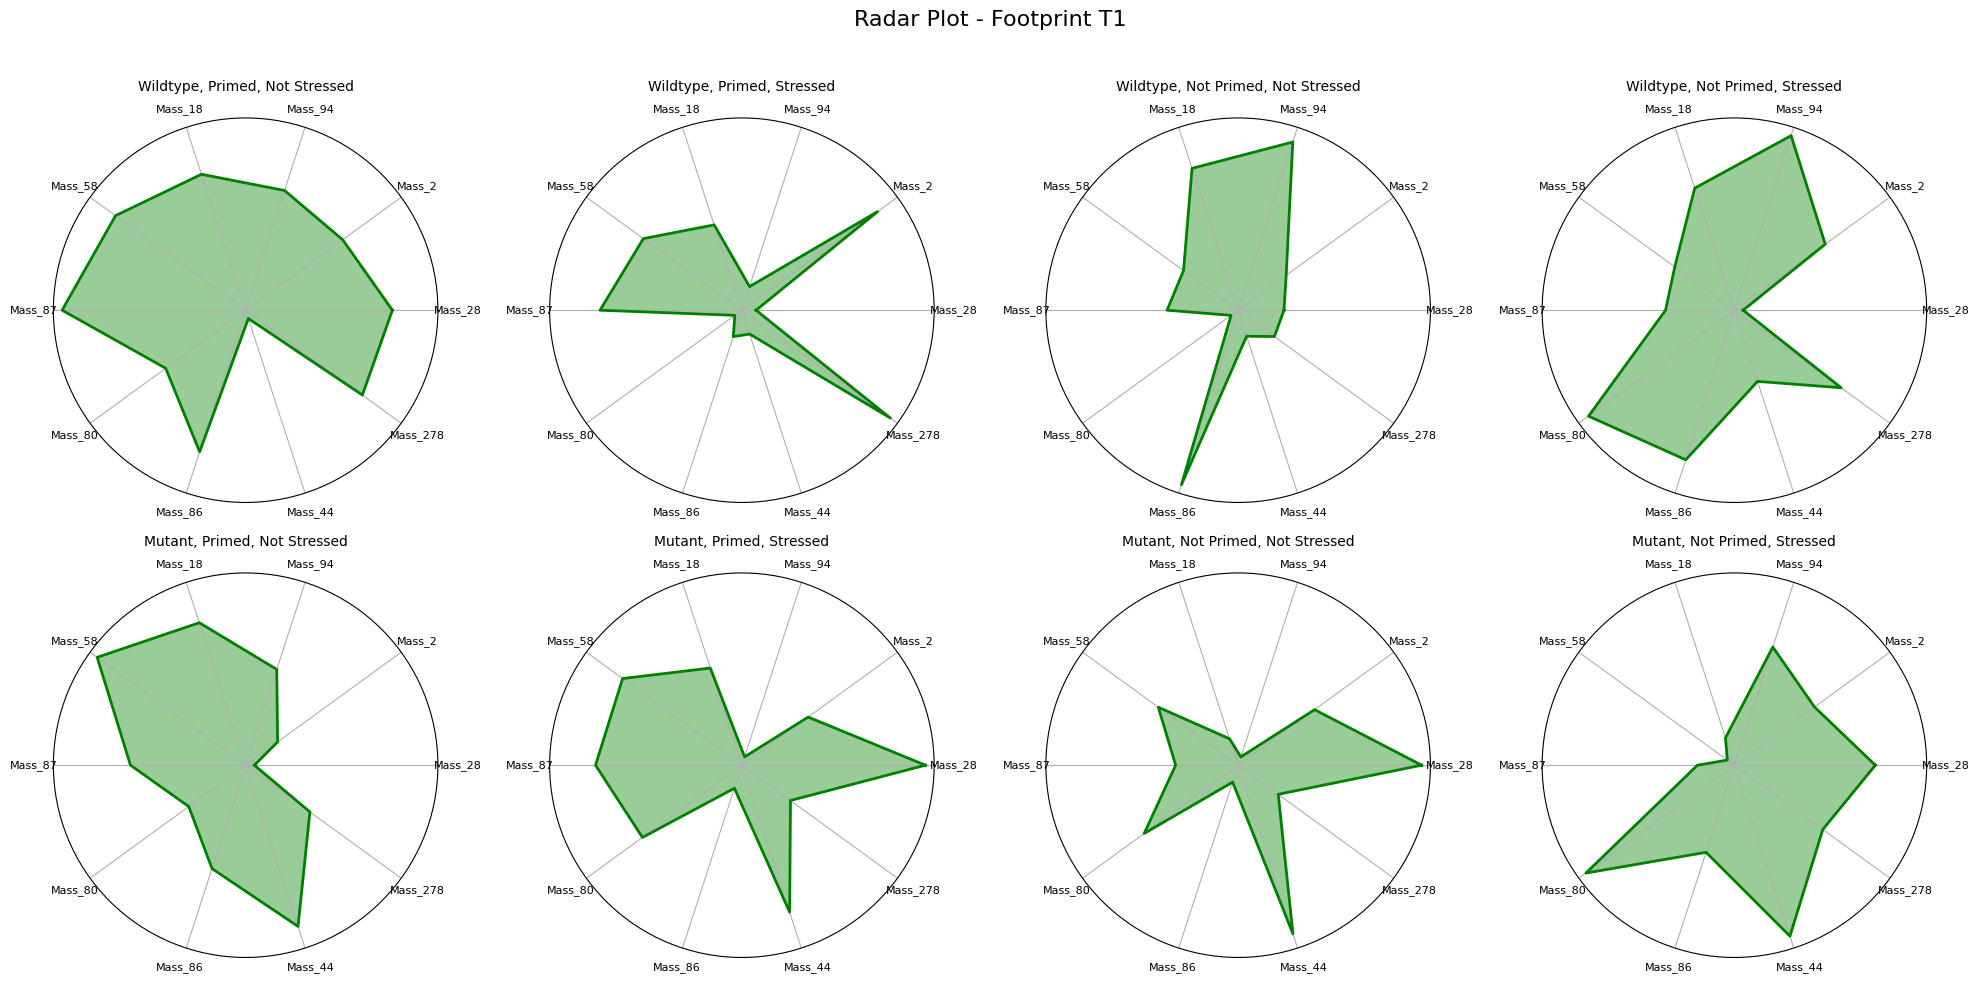



Graph generation for time: T2


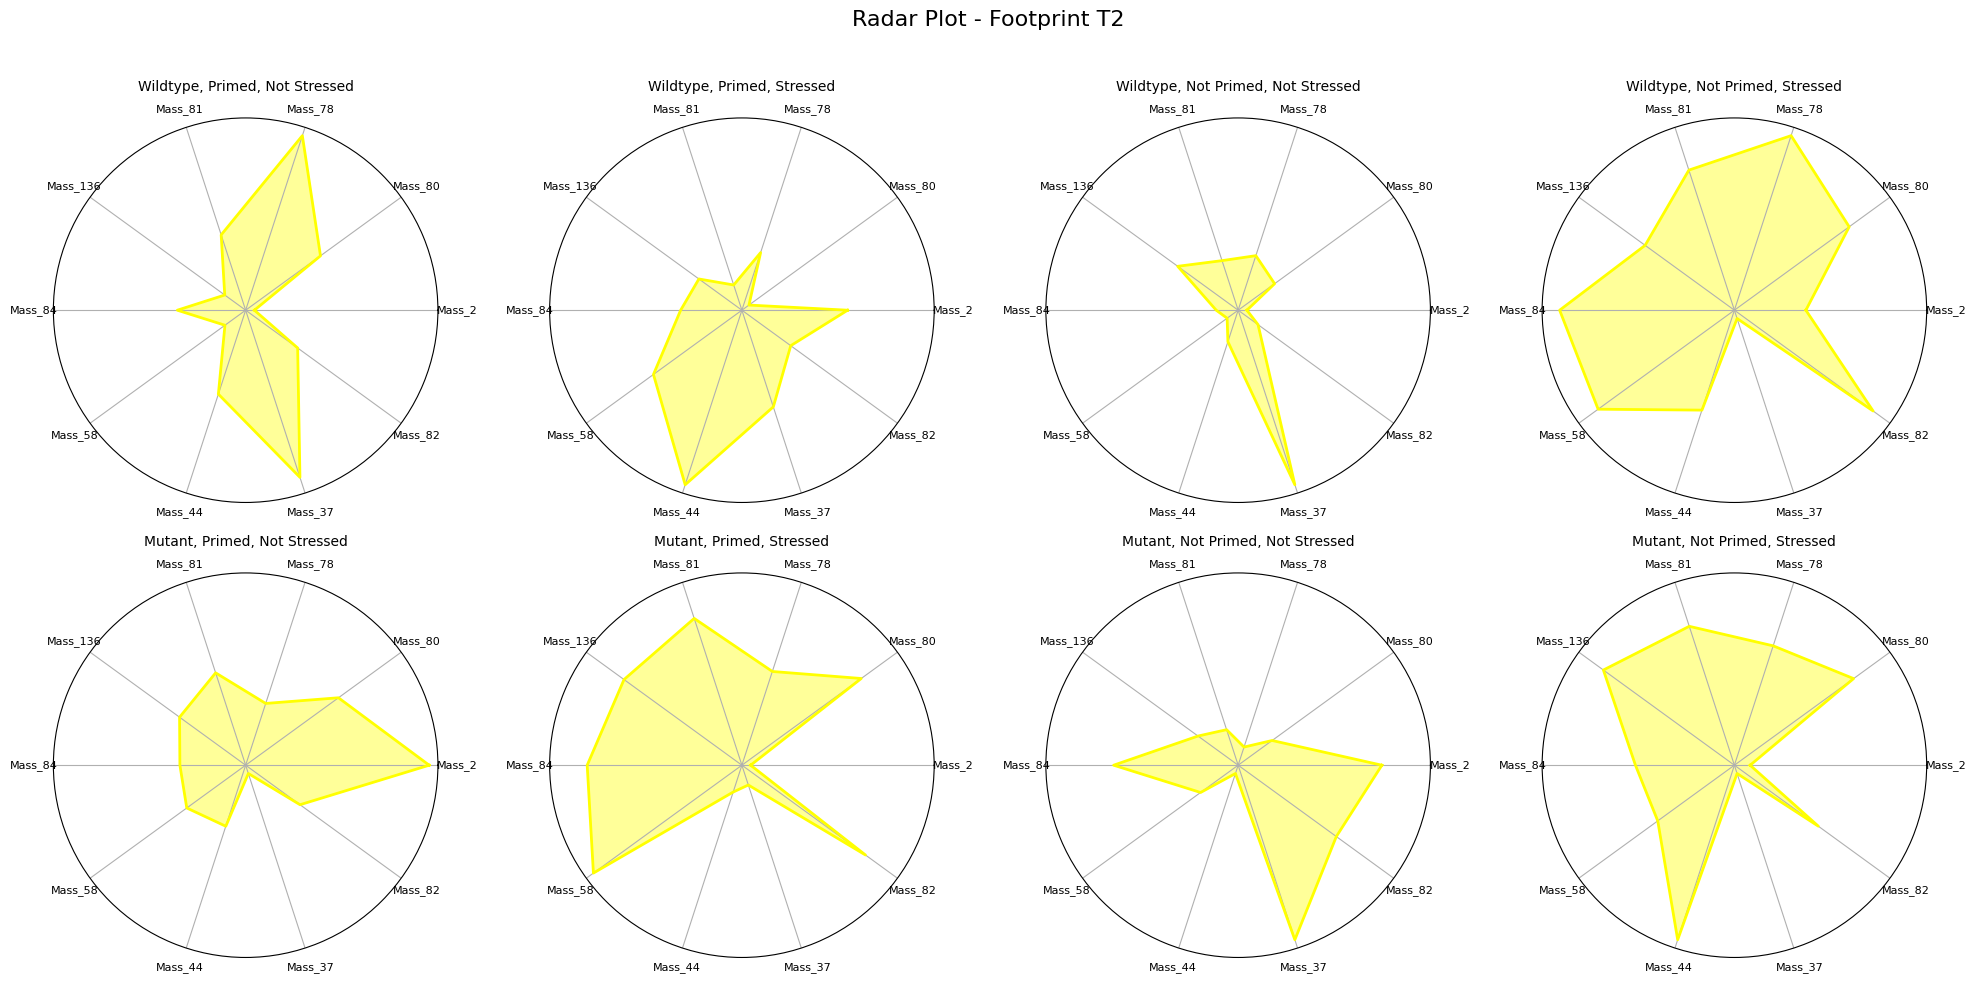



Graph generation for time: T3


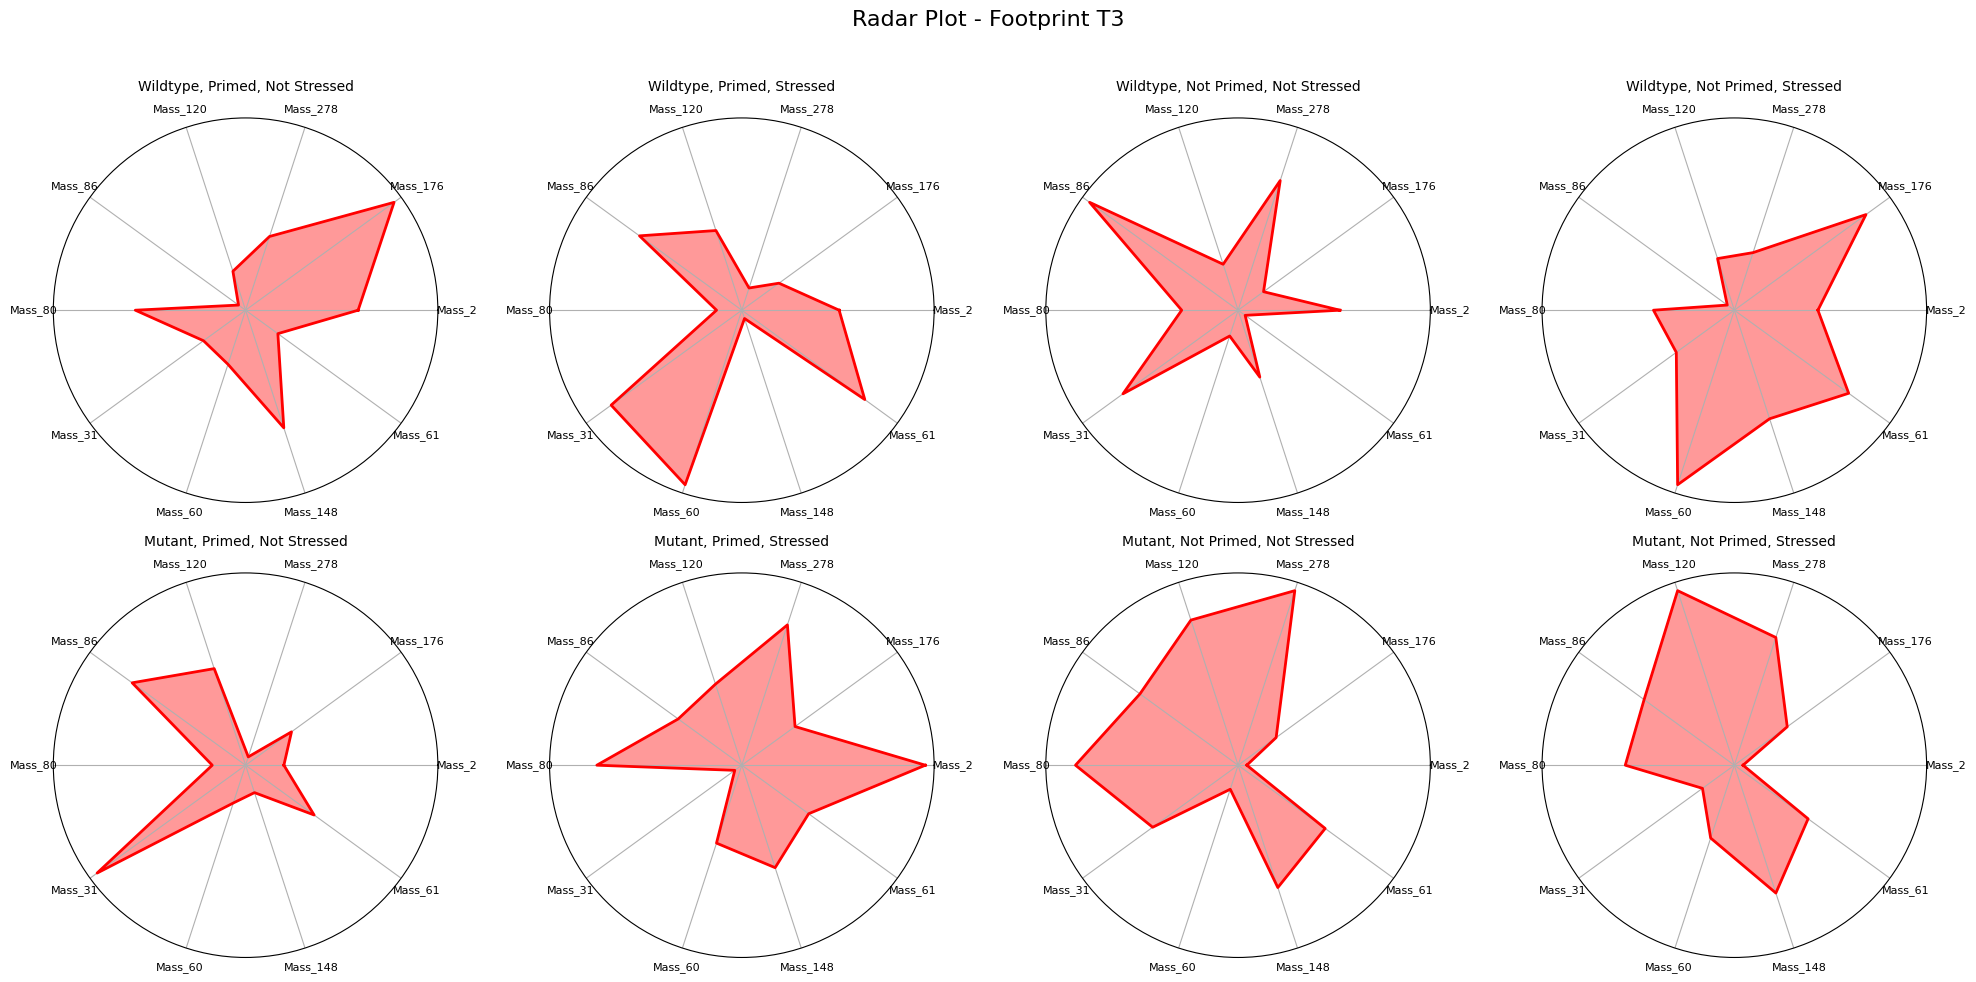

In [ ]:
# Define a dictionary to map each time key to a specific color.
color_dict = {
    "T1": "green",
    "T2": "yellow",
    "T3": "red",
}

# Iterate over each item (time point and corresponding DataFrame) in the footprints_data dictionary.
for time_key, footprints_df in footprints_data.items():
    print(f"\n\nGraph generation for time: {time_key}")  # Inform which time point is being processed.

    # Get the color associated with the current time_key from the color_dict.
    # If the key is not found, color will be None (you may want to provide a default if needed).
    color = color_dict.get(time_key)

    # Generate the radar plots for the current DataFrame using the chosen color.
    plot_radar_charts(
        footprints=footprints_df,
        top_masses=10,
        title=f"Radar Plot - Footprint {time_key}",
        color=color
    )

By analyzing the three times separately, it is not possible to totally compare the results because **at different times the most significant features are mostly different**. The focus can only be on the features' intersections.


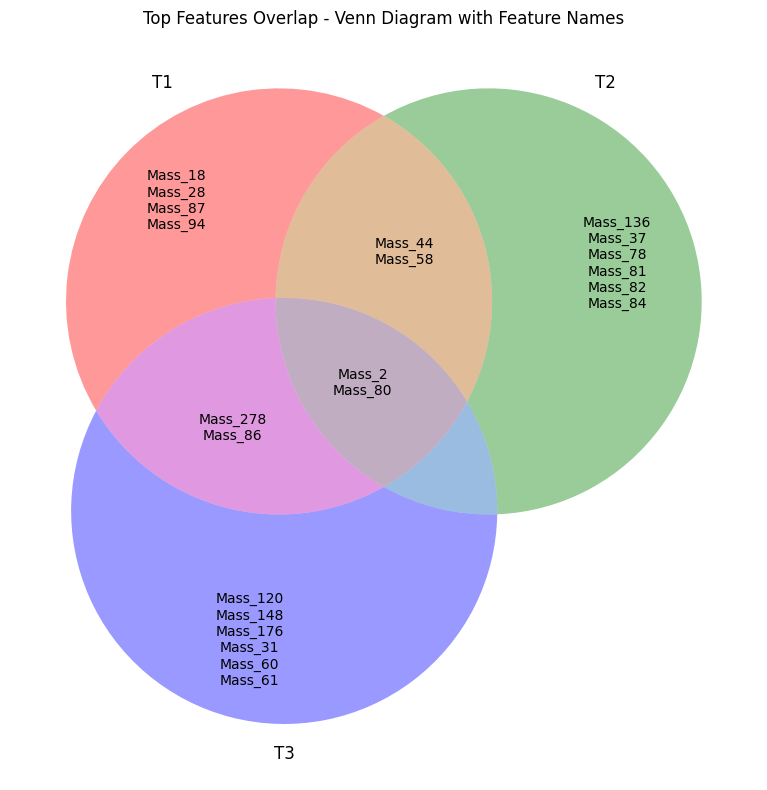

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Get top N features for each dataset
top_T1 = set(feature_importance["T1"].head(top_n_features)["Feature"].values)
top_T2 = set(feature_importance["T2"].head(top_n_features)["Feature"].values)
top_T3 = set(feature_importance["T3"].head(top_n_features)["Feature"].values)

# Create the Venn diagram object
plt.figure(figsize=(10, 8))
venn = venn3([top_T1, top_T2, top_T3], set_labels=('T1', 'T2', 'T3'))

# Define each area in the Venn diagram and add feature names
subsets = {
    '100': top_T1 - top_T2 - top_T3,
    '010': top_T2 - top_T1 - top_T3,
    '001': top_T3 - top_T1 - top_T2,
    '110': top_T1 & top_T2 - top_T3,
    '101': top_T1 & top_T3 - top_T2,
    '011': top_T2 & top_T3 - top_T1,
    '111': top_T1 & top_T2 & top_T3,
}

# Update the Venn labels with actual feature names
for key, features in subsets.items():
    label = venn.get_label_by_id(key)
    if label:
        label.set_text("\n".join(sorted(features)))

plt.title("Top Features Overlap - Venn Diagram with Feature Names")
plt.tight_layout()
plt.show()

###**FOOTPRINTS UPDATE**
Columns for **_Mass_44_** and **_Mass_58_** were added to the dataframes based on the intersection of T1 and T2, as well as columns for **_Mass_278_** and **_Mass_86_** from the intersection of T1 and T3.

In [ ]:
# List of additional masses to include if available
extra_masses = ['Mass_58', 'Mass_44', 'Mass_86', 'Mass_278']
# Dictionary to store the updated list of top features per timepoint
extended_top_features = {}

# Iterate over each timepoint and its corresponding top features
for time, features in top_features_per_time.items():
    # Get the set of available masses (columns) in the dataframe for the current timepoint
    available_masses = set(final_dataframes[time].columns)
    # Convert the current top features to a set for easy manipulation
    new_features = set(features)

    # Check if each extra mass is available in the current dataframe and add it if so
    for mass in extra_masses:
        if mass in available_masses:
            new_features.add(mass)

    # Store the extended feature list (converted back to a list) for the current timepoint
    extended_top_features[time] = list(new_features)

    # Print a summary showing how many features were added and which extra masses were not already in the top features
    print(f"{time} -> extended to {len(new_features)} features (added: {set(extra_masses) - set(features)})")


T1 -> extended to 10 features (added: set())
T2 -> extended to 12 features (added: {'Mass_278', 'Mass_86'})
T3 -> extended to 12 features (added: {'Mass_58', 'Mass_44'})


In [ ]:
filtered_dataframes = filter_top_features(final_dataframes, extended_top_features)

Filtered DataFrame for T1 with shape (39, 13)
Filtered DataFrame for T2 with shape (38, 15)
Filtered DataFrame for T3 with shape (34, 15)


In [ ]:
footprints_data = {}

for key, df in filtered_dataframes.items():

    # Group data for combinations of Genotype, Priming and Stress.
    grouped = df.groupby(['Genotipo', 'Priming', 'Stress'])

    # Calculate the average for each group (thesis).
    footprints = grouped.mean().reset_index()

    # It adds the result to the footprint dictionary for each time.
    footprints_data[key] = footprints

    print(f"\nFootprints calculated for {key} with shape {footprints.shape}\n")

    print(footprints_data[key])

    # Separator to improve readability.
    print("\n" + "="*50 + "\n")


Footprints calculated for T1 with shape (8, 13)

   Genotipo  Priming  Stress  Mass_278   Mass_58   Mass_87   Mass_18  \
0     False    False   False  0.154157  0.266194  0.419946  0.144838   
1     False    False    True  0.619724  0.240206  0.363724  0.043175   
2     False     True   False -0.226164 -0.018860  0.013786  0.726167   
3     False     True    True -0.003155 -0.339064 -0.367042 -0.023953   
4      True    False   False -0.047130  0.396992  0.105434  0.253177   
5      True    False    True -0.293805  0.197763  0.191755 -0.057069   
6      True     True   False -0.514326 -0.143050 -0.416477 -0.679039   
7      True     True    True  0.301273 -0.520782 -0.290039 -0.356659   

     Mass_2   Mass_28   Mass_86   Mass_44   Mass_80   Mass_94  
0 -0.011070  0.170619  0.185161 -0.764630 -0.154168  0.029309  
1  0.522488 -0.421046 -0.337642 -0.353888 -0.454470 -0.355700  
2 -0.092886 -0.216224  1.039956 -0.384809 -0.555047  0.978918  
3 -0.116362 -0.713569  0.143128 -0.332333  0.

In this section the attention is put on looking at the **trend of common masses** within the **eight possible theses**.

The previously calculated footprints are filtered considering only the *extended_top_features* and then their values throughout T1, T2 and T3 are plot drawing curves that describe their courses.

In [ ]:
def plot_mass_curves_by_group(footprints_data, top_masses, times, title="Time trend by group", mass_colors=None):
    """
    Graphs the time course of the selected masses (top_masses) divided into groups defined by the combinations of
    `Genotype`, `Priming`, and `Stress`.

    Parameters:
    - footprints_data: Dictionary with DataFrames containing footprints for each time {time: DataFrame}.
    - top_masses: List of column names of the masses to be considered.
    - times: Time List (e.g., ['T1', 'T2', 'T3']).
    - title: General title of the graph.
    """
    import matplotlib.pyplot as plt

    # Find all unique combinations of Genotype, Priming, and Stress.
    combinations = []
    for df in footprints_data.values():
        combinations.extend(df[['Genotipo', 'Priming', 'Stress']].drop_duplicates().values.tolist())
    combinations = sorted(set(map(tuple, combinations)))  # Removes duplicates and sorts.

    # Configure the grid.
    nrows, ncols = len(set(c[0] for c in combinations)), len(set(c[1:] for c in combinations))  # Divide by Genotipo and other factors.
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12), sharex=True, sharey=True)
    axes = axes.flatten()

    # Plot for each combination.
    for idx, (genotipo, priming, stress) in enumerate(combinations):
        ax = axes[idx]

        # Data collection for the specific combination.
        df_group = {time: df[(df['Genotipo'] == genotipo) &
                             (df['Priming'] == priming) &
                             (df['Stress'] == stress)]
                    for time, df in footprints_data.items()}
        mass_values = {mass: [] for mass in top_masses}

        for time in times:
            for mass in top_masses:
                # Derives the average value for that mass, for that time.
                mass_values[mass].append(df_group[time][mass].mean() if not df_group[time].empty else None)

        # Line plot for each mass.
        for mass, values in mass_values.items():
            color = mass_colors[mass] if mass_colors and mass in mass_colors else None
            ax.plot(times, values, marker='o', label=mass, color=color)

        # Graph title.
        genotipo_str = "Mutante" if genotipo else "Wildtype"
        priming_str = "Primed" if priming else "Not Primed"
        stress_str = "Stress" if stress else "Not Stressed"
        ax.set_title(f"{genotipo_str}, {priming_str}, {stress_str}", fontsize=10)
        ax.grid(True, alpha=0.3)

    # Unique legend in the top-right corner.
    fig.legend(labels=top_masses, loc='upper right', fontsize=10, ncol=1, title="Masses", title_fontsize=12)

    # Adjust layout to prevent overlap.
    plt.suptitle(title, fontsize=16, y=0.98)  # Moves the title slightly higher.
    plt.xlabel("Times", fontsize=14)
    plt.ylabel("Mean intensity", fontsize=14)
    fig.subplots_adjust(top=0.9)  # Ensures there is enough space for the title and the legend.
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Extra adjustments for better spacing.
    plt.show()


The **color scheme** adopted in the visualizations was designed to **highlight the overlap of features across different time points**.

- Features that appear in the **top 10 for both Time 1 and Time 2** are marked in **green** (light and dark shades),  
- while those shared between **Time 1 and Time 3** are represented in **purple** (light and dark tones).

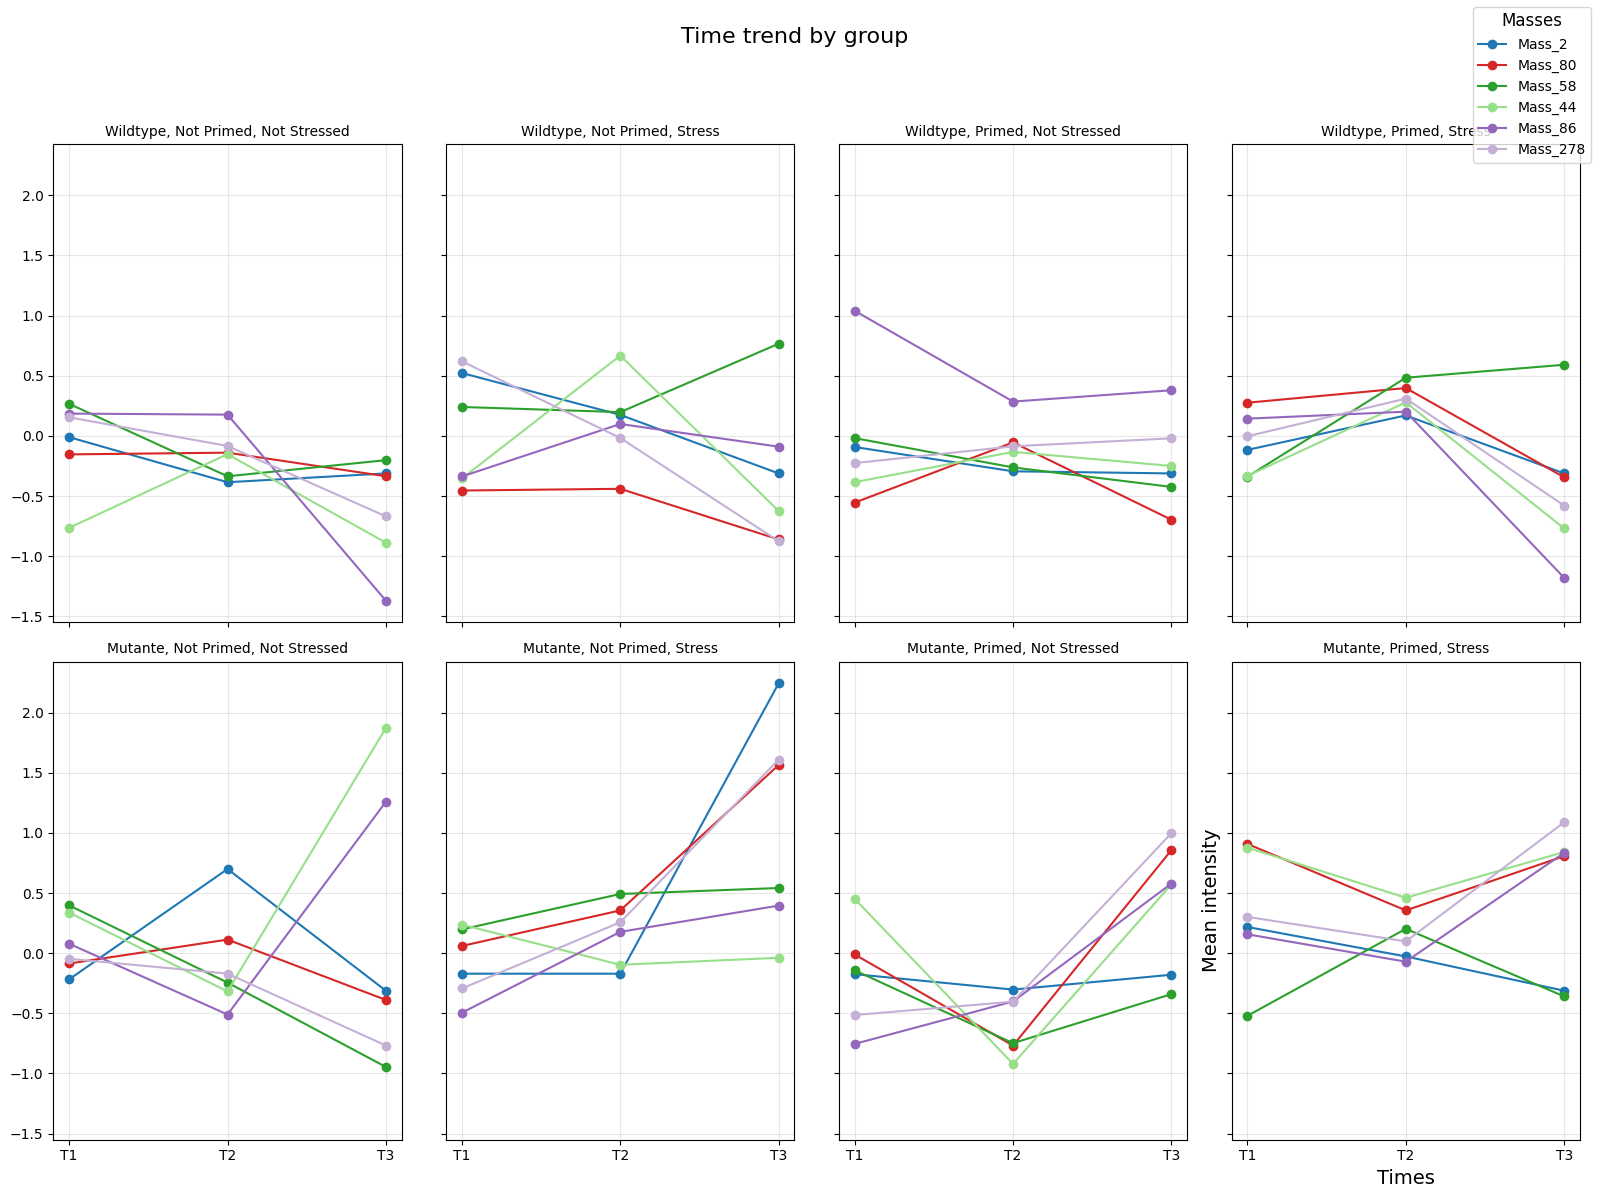

In [ ]:
# List of the most important masses.
top_masses = ['Mass_2', 'Mass_80', 'Mass_58', 'Mass_44', 'Mass_86', 'Mass_278']
mass_colors = {
    'Mass_2': '#1f77b4',     # blue
    'Mass_80': '#d62728',    # red
    'Mass_58': '#2ca02c',    # dark green
    'Mass_44': '#98df8a',    # light green
    'Mass_86': '#9467bd',    # dark purple
    'Mass_278': '#c5b0d5'    # light purple
}

# Time list.
times = ['T1', 'T2', 'T3']

# Generates the graph.
plot_mass_curves_by_group(footprints_data, top_masses, times, mass_colors=mass_colors)


##**PRELIMINARY ANALYSIS: TIME-RESOLVED PCA**


The **line plots** illustrating the **temporal trends** of the mass values across experimental conditions reveal **clear differences in mass variability**:

- Under **baseline conditions** (*wildtype, not primed, not stressed*), the masses exhibit **minimal fluctuations** and a **relatively homogeneous distribution**. This reflects the **default chemical profile** of the plant in the absence of external stimuli.  
- When plants are exposed to **direct stress** (*wildtype, not primed, stressed*), a **marked increase in variability** is observed, particularly in compounds such as **Mass_2** and **Mass_80**. This suggests that active stress triggers a **disorganized or chaotic chemical response**, typical of an **altered physiological state**.  
- **Primed but non-stressed plants** (*wildtype, primed, not stressed*) display a **more stable pattern**, with **limited fluctuations** in key mass features. This indicates that **contact with stressed plants** may elicit a **preparatory response**, enhancing the plant's **resilience** and maintaining a more **balanced chemical profile**.  
- In the condition of **both primed and stressed** (*wildtype, primed, stressed*), variability increases again, although **less intensely** than in the non-primed group. In this case too, **Mass_2** and **Mass_80** appear to be **strongly involved**.

Both **wildtype** and **mutant** plants display **similar patterns** across experimental groups. However, **mutants tend to show slightly higher variability**, particularly under stress. This may suggest that the **genetic mutation impairs** the plant’s ability to **regulate or buffer its stress response**, leading to a **greater chemical imbalance**.

When examining the **overall mass distributions**, a few **consistent patterns** emerge:

- **Stress increases mass variability** across all conditions.
- **Priming exerts a stabilizing effect**, reducing variability.
- This effect is observed in both wildtype and mutant lines, though it is **less pronounced** in mutants.

Among the top-ranked features across all time points, **Mass_2** and **Mass_80** stand out as **consistently relevant**. These are likely to represent **key volatile compounds** involved in the **stress response** and potentially in **plant-to-plant chemical communication**.

The **temporal curves** of these masses follow a **coherent trajectory**: they **increase under direct stress**, but remain **more moderate and controlled** in primed plants. This strongly suggests that **primed individuals activate a defensive response** even in the absence of direct stress exposure, supporting the hypothesis that **chemical signals are being perceived** from neighboring stressed plants.

In **temporal datasets**, the **importance of a feature** can vary over time. A specific mass may be **highly discriminative** at a particular time point (e.g., **T1**) but become **less relevant** at other time points. When data from multiple time points are **combined**, the **overall importance** of such a feature may decrease compared to others that exhibit a **more consistent relevance** across time.

In some cases, a mass may appear important in an individual time point due to **noise** or **context-specific variability**. When these effects are averaged out in the **aggregated analysis**, the **relative importance** of that mass tends to diminish.

**As a result**, we conducted a **second analysis** using a **single aggregated dataset** that incorporates measurements from **all three time points**, allowing us to capture features that are **relevant across temporal scales** and assess their **global discriminative power**.

##**DATA ANALYSIS #2: THREE-TIME UNION**

Considering the results obtained, a **broader perspective** analysis is now being considered.

In this section, PCA is performed on a **dataset** comprising **measurements taken over all three periods**.

Unlike the earlier stages of analysis where plots were generated separately for each temporal snapshot, this step **aggregates the data** to uncover overarching patterns across the **full experimental timeline**.

###**PRE-PROCESSING AND PCA**

In [ ]:
# Concatenation of DataFrames.
final_df = pd.concat(final_dataframes.values(), axis=0)

# Selection of numeric columns only (excluding categorical).
numeric_features = final_df.select_dtypes(include=["number"]).dropna()

# Number of main components to be calculated.
n_components = 10

# Initialise PCA.
pca = PCA(n_components=n_components)

# Performs PCA on the numeric dataset.
pca_transformed = pca.fit_transform(numeric_features)

# Creates a DataFrame for the PCA results.
pca_columns = [f"PC{i+1}" for i in range(pca_transformed.shape[1])]
pca_df = pd.DataFrame(data=pca_transformed, columns=pca_columns, index=numeric_features.index)

print(f"PCA completed. Results: {pca_df.shape}")

PCA completed. Results: (109, 10)


###**FEATURE IMPORTANCE**
After performing PCA on the merged dataset, this section computes **Feature Importance** based on the **absolute contributions** of each original variable to the **overall principal components**.



In [ ]:
# It obtains the loading scores (matrice components_ of PCA).
loading_scores = pca.components_

# Calculation of feature importance considering the contribution on all n_components.
importance_per_component = pd.DataFrame(
    data=loading_scores.T,  # Transpose to have features as rows and components as columns.
    columns=[f"PC{i+1}" for i in range(loading_scores.shape[0])],
    index=numeric_features.columns
)

# Aggregates the importance along all the main components.
aggregated_importance = importance_per_component.abs().sum(axis=1).sort_values(ascending=False)

# Creates a DataFrame that sorts features by total importance.
feature_importance_df = pd.DataFrame({
    "Feature": aggregated_importance.index,
    "Importance": aggregated_importance.values,
})

print(f"Feature importance calculated. Total features: {len(aggregated_importance)}")

# Print the top 10 features by importance.
print("\nTop 10 features by overall importance in PCA:")
print(feature_importance_df.head(10))


Feature importance calculated. Total features: 524

Top 10 features by overall importance in PCA:
    Feature  Importance
0    Mass_2    1.308021
1  Mass_176    1.149052
2   Mass_80    1.148079
3   Mass_58    1.135448
4   Mass_44    1.124104
5  Mass_148    1.080523
6   Mass_31    1.021993
7   Mass_84    1.003049
8   Mass_37    0.990744
9   Mass_81    0.970340


It is important to highlight the **disappearance of certain masses** that were relevant in the individual time-point analyses but **do not appear** in the aggregated analysis. Specifically, **Mass_278** and **Mass_86**, which were both included among the **top 10 features** in two out of the three time points, are **absent** from the global feature ranking.

This phenomenon can be interpreted as an indication of their **temporal specificity**. These masses may correspond to **compounds that are active only during specific phases** of the plant’s stress response, or they might represent **transient signals** with high importance **only at particular moments**.

Their absence in the aggregated analysis suggests that they **do not play a consistently strong role over time**, making them **less robust candidates** as potential **biomarkers** when compared to features that persist **consistently** across multiple conditions and time points.

###**FILTERING**

In [ ]:
# Extract the names of the top 10 features based on overall importance.
global_top_features = feature_importance_df.head(10)["Feature"].values

# Display the top 10 most important features.
print("Top 10 features by overall importance:")
print(global_top_features)

global_filtered_dataframes = {}

for key, df in final_dataframes.items():

    # Filters the DataFrame to include only the top features.
    filtered_features = global_top_features
    global_filtered_df = df[filtered_features]

    # Adds classification columns to the dataset.
    global_filtered_df['Genotipo'] = df['Genotipo_Mutante']
    global_filtered_df['Priming'] = df['Priming_Control']
    global_filtered_df['Stress'] = df['Stress_Stress']

    global_filtered_dataframes[key] = global_filtered_df

    print(f"DataFrame filtered by {key} with shape {global_filtered_df.shape}")


Top 10 features by overall importance:
['Mass_2' 'Mass_176' 'Mass_80' 'Mass_58' 'Mass_44' 'Mass_148' 'Mass_31'
 'Mass_84' 'Mass_37' 'Mass_81']
DataFrame filtered by T1 with shape (39, 13)
DataFrame filtered by T2 with shape (38, 13)
DataFrame filtered by T3 with shape (34, 13)


/tmp/ipython-input-4084441717.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_filtered_df['Genotipo'] = df['Genotipo_Mutante']
/tmp/ipython-input-4084441717.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_filtered_df['Priming'] = df['Priming_Control']
/tmp/ipython-input-4084441717.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

###**FOOTPRINTS**
In this code, the focus is on calculating footprints across different time points.

The footprints calculated in this manner provide a summary of **how the plants behave** across different genotypes, priming and stress statuses, from the **point of view of the most meaningful massess** among T1, T2 and T3.

In [ ]:
footprints_data = {}

for key, df in filtered_dataframes.items():

    # Group data for combinations of Genotype, Priming and Stress.
    grouped = df.groupby(['Genotipo', 'Priming', 'Stress'])

    # Calculate the average for each group (thesis).
    footprints = grouped.mean().reset_index()

    # It adds the result to the footprint dictionary for each time.
    footprints_data[key] = footprints

    print(f"\nFootprints calculated for {key} with shape {footprints.shape}\n")

    print(footprints_data[key])

    # Separator to improve readability.
    print("\n" + "="*50 + "\n")


Footprints calculated for T1 with shape (8, 13)

   Genotipo  Priming  Stress  Mass_278   Mass_58   Mass_87   Mass_18  \
0     False    False   False  0.154157  0.266194  0.419946  0.144838   
1     False    False    True  0.619724  0.240206  0.363724  0.043175   
2     False     True   False -0.226164 -0.018860  0.013786  0.726167   
3     False     True    True -0.003155 -0.339064 -0.367042 -0.023953   
4      True    False   False -0.047130  0.396992  0.105434  0.253177   
5      True    False    True -0.293805  0.197763  0.191755 -0.057069   
6      True     True   False -0.514326 -0.143050 -0.416477 -0.679039   
7      True     True    True  0.301273 -0.520782 -0.290039 -0.356659   

     Mass_2   Mass_28   Mass_86   Mass_44   Mass_80   Mass_94  
0 -0.011070  0.170619  0.185161 -0.764630 -0.154168  0.029309  
1  0.522488 -0.421046 -0.337642 -0.353888 -0.454470 -0.355700  
2 -0.092886 -0.216224  1.039956 -0.384809 -0.555047  0.978918  
3 -0.116362 -0.713569  0.143128 -0.332333  0.

In [ ]:
global_footprints_data = {}

for key, df in global_filtered_dataframes.items():
    print(f"Calculation of focused footprints for {key}...")

    # Group the data by Genotype (wildtype/mutant) and Priming (primed/not primed).
    grouped = df.groupby(['Genotipo', 'Priming', 'Stress'])

    # Calculate the average for each group.
    footprints = grouped.mean(numeric_only=True).reset_index()

    # Reposition the “Stress” column to the desired position.
    columns = list(footprints.columns)
    #columns.remove('Stress')  # Temporarily removes “Stress” from the list.
    #columns.insert(2, 'Stress')  # Enter “Stress” in position 3.
    footprints = footprints[columns]  # Re-order the columns.

    # Adds the result to the footprint dictionary for this time.
    global_footprints_data[key] = footprints

    print(f"Calculated footprints for{key} with shape {footprints.shape}")


Calculation of focused footprints for T1...
Calculated footprints forT1 with shape (8, 13)
Calculation of focused footprints for T2...
Calculated footprints forT2 with shape (8, 13)
Calculation of focused footprints for T3...
Calculated footprints forT3 with shape (8, 13)


###**RADAR PLOTS SYNTHESIS**

By plotting data from **all three time points on the same graph**, it becomes possible to directly **compare and assess the temporal differences** in how the plants respond under various conditions.


In [ ]:
def plot_radar_by_group(footprints_data, top_masses, times, title="Radar Plot for group"):
    """
    It generates overlapping radar plots for each combination of Genotype, Priming and Stress,
    with differentiated colours for each time.

    Modified to use a 2x4 grid as in plot_radar_charts.
    """
    # Find all unique combinations of Genotype, Priming, and Stress.
    combinations = []
    for df in footprints_data.values():
        combinations.extend(df[['Genotipo', 'Priming', 'Stress']].drop_duplicates().values.tolist())
    combinations = sorted(set(map(tuple, combinations)))  # Remove duplicates and sort.

    # Configure subplot grid layout to 2x4 grid
    nrows, ncols = 2, 4  # Grid 2x4 for 8 combinations
    num_combinations = len(combinations)
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10), subplot_kw={'polar': True})
    axes = axes.flatten()
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

    # Calculate angles for radar axes.
    num_vars = len(top_masses)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Closing the circle

    # Fixed color mapping for times.
    time_color_dict = {'T1': 'green', 'T2': 'yellow', 'T3': 'red'}
    color_list = [time_color_dict.get(t, 'grey') for t in times]

    # Radar plot for each combination.
    for idx, (genotipo, priming, stress) in enumerate(combinations):
        ax = axes[idx]

        # Collect data for this specific combination from each time.
        df_group = {
            time: df[
                (df['Genotipo'] == genotipo) &
                (df['Priming'] == priming) &
                (df['Stress'] == stress)
            ]
            for time, df in footprints_data.items()
        }

        for i, time in enumerate(times):
            df = df_group.get(time)
            if df is not None and not df.empty:
                values = [df[mass].mean() for mass in top_masses]
                values += values[:1]  # Closing the circle
                ax.plot(angles, values, color=color_list[i], linewidth=2, linestyle='solid', label=f"{time}")
                ax.fill(angles, values, color=color_list[i], alpha=0.25)

        # Format the group label as requested: "Genotipo, Priming, Stress"
        genotipo_str = "Mutante" if genotipo else "Wildtype"
        priming_str = "Primed" if priming else "Not Primed"
        stress_str = "Stressed" if stress else "Not Stressed"
        group_title = f"{genotipo_str}, {priming_str}, {stress_str}"
        ax.set_title(group_title, fontsize=10, pad=30, loc='center')  # Increase pad to avoid overlap.

        ax.set_yticks([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(top_masses, fontsize=8)

    # Hide any empty axes if there are fewer combinations than grid slots
    for j in range(num_combinations, len(axes)):
        axes[j].axis('off')

    # Legend in the top right
    proxy_artists = [plt.Line2D([0], [0], color=color_list[i], lw=2) for i in range(len(times))]
    fig.legend(
        proxy_artists,
        times,
        loc='upper right',
        bbox_to_anchor=(0.98, 0.98),
        ncol=1,
        title="Time",
        fontsize=10,
        title_fontsize=12
    )

    plt.suptitle(title, fontsize=16, y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=0.4, top=0.88)
    plt.show()

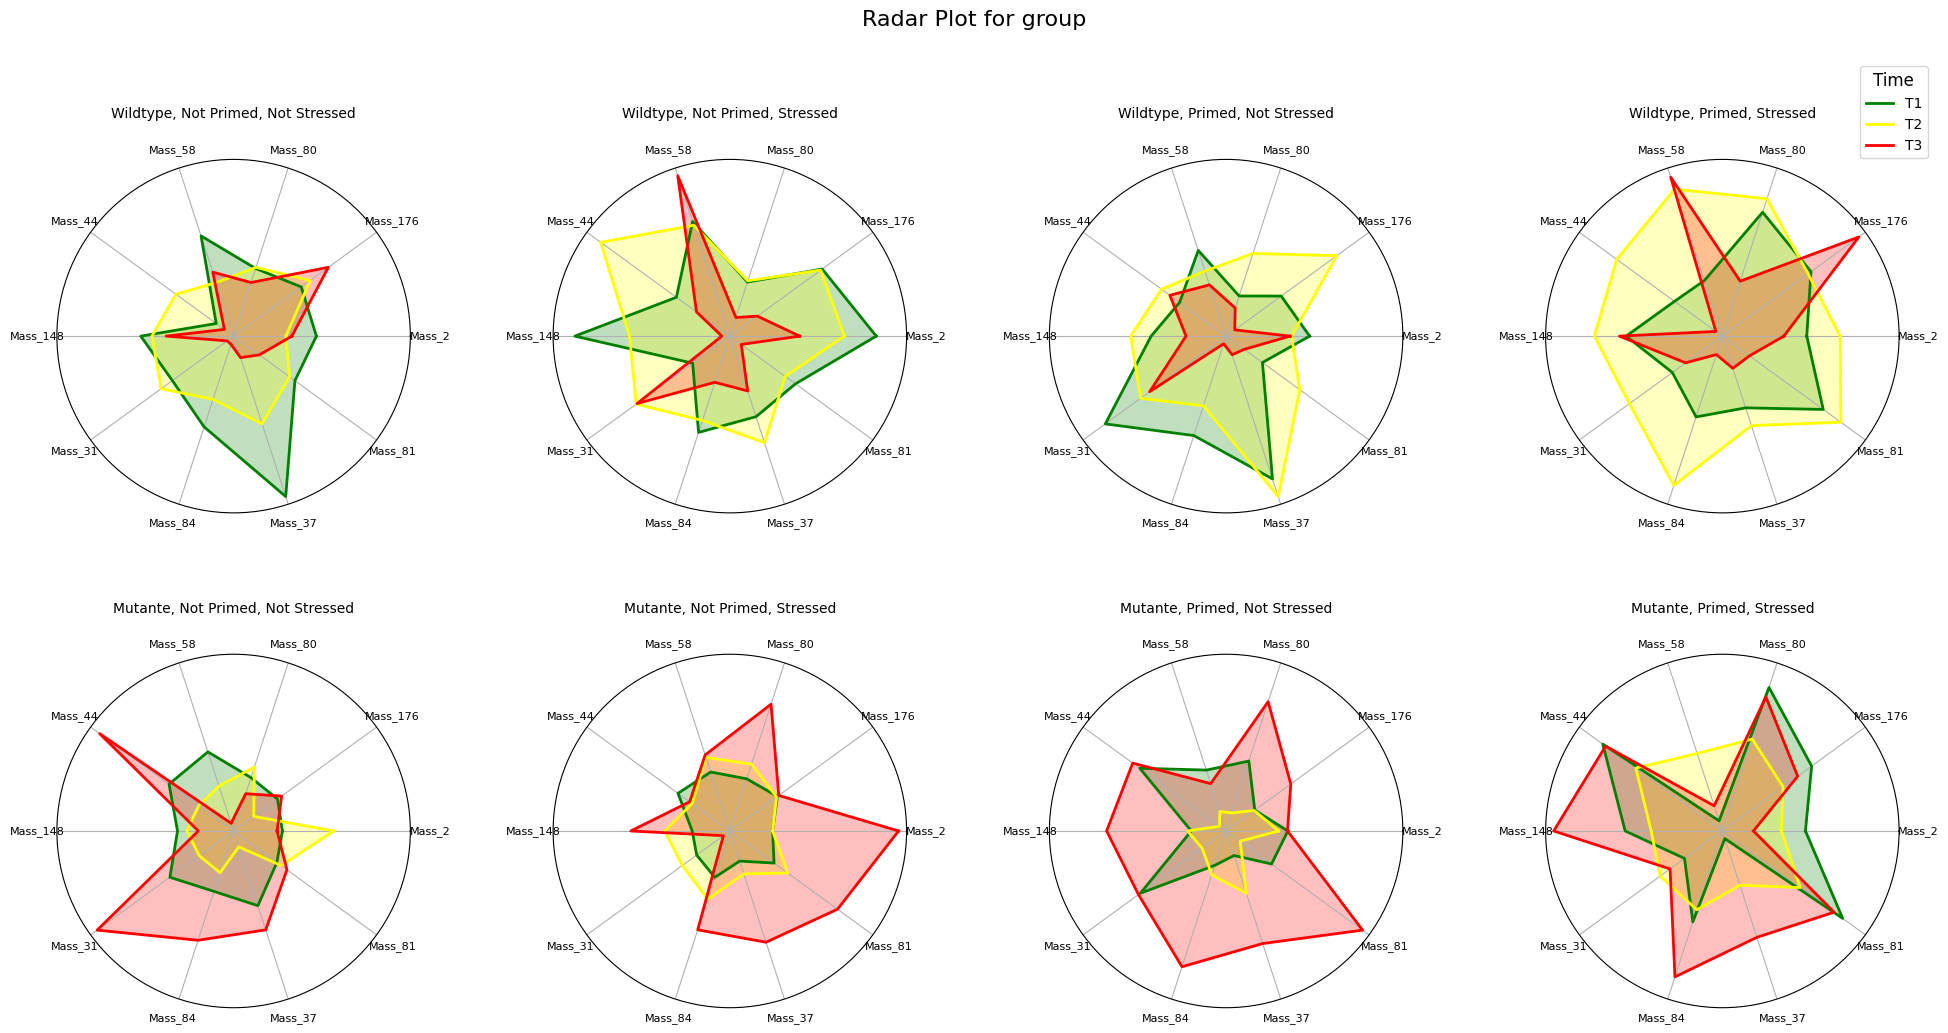

In [ ]:
# List of the most important masses.
top_masses = global_top_features

# Time list.
times = ['T1', 'T2', 'T3']

# Generates the graph.
plot_radar_by_group(global_footprints_data, top_masses, times)


##**FINAL ANALYSIS: INTEGRATED PCA AND BIOMARKER IDENTIFICATION**

A particularly relevant outcome of this second analysis is the **recurring presence** of certain masses (**Mass_2**, **Mass_80**, **Mass_58**, and **Mass_44**) among the **most important features**, both in the datasets analyzed **individually by time point** and in the **aggregated dataset**.

From a **statistical perspective**, this level of **consistency** is highly meaningful: it indicates that these masses do not represent **transient signals**, but rather **stable and reproducible patterns** that contribute significantly to **class separation** in the **principal components** of the PCA. This redundancy across **independent and aggregated analyses** serves as strong evidence of **signal robustness**, reinforcing the hypothesis that these masses are **informative biomarkers** involved in **plant communication**.

The **radar plots**, based on the aggregated analysis, display the **average intensities** for each combination of experimental conditions. Compared to the previously shown **temporal curves** (from the time-specific analysis), these visualizations highlight **marked differences between groups**, especially for **Mass_2** and **Mass_80**. **Primed plants** exhibit **higher or more stable profiles** for these masses than their **non-primed counterparts**, in both **wildtype** and **mutant** conditions.

These observations further support the value of these masses as **reliable markers of chemical priming**, clearly detectable not only at **individual time points** but also from a **broader, integrated perspective**.

## **CONCLUSION**

The set of analyses presented provides **compelling evidence** for the existence of a **plant-to-plant communication mechanism** mediated by **chemical signals**. **Primed plants** develop **distinctive and more stable mass profiles** compared to non-primed ones, even in the absence of direct stress exposure.

Certain masses, particularly **Mass_2** and **Mass_80**, emerge as **key markers**, consistently identifiable across **different time points** and **experimental conditions**. These findings pave the way for more **in-depth investigations** into the **chemical identity** of these signals and the **physiological mechanisms** underlying **interplant communication**.